# Jupyter Notebook zum Import/Export, zur Analyse und Darstellung von Zeitreihendaten
[Module: python pandas, matplotlib, numpy]


## 1. Funktionen definieren
hier werden Funktionen definiert, die in unteren Zellen aufgerufen werden.
1. plotdf: grafische Darstellung der Zeitreihen
2. getdf_frommulticsv: Import der csv-Daten in einen Datenframe (df)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
pd.options.mode.chained_assignment = None  #pandas Warnungen ausblenden
df = pd.DataFrame(np.random.randn(3, 2), columns=list('AB')) #df-dummy wird in nächster Zelle überschireben

def plotdf(df, startdate,enddate):
     
    plt.rcParams['figure.figsize'] = [20,15] 
    plt.rcParams['figure.dpi'] = 200
    colortable=['b','g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r', 'c', 'm', 'y', 'k']
    dfloc=df.loc[startdate:enddate]
    dflen=len(df.columns)
    fig, ax=plt.subplots(dflen)
    #ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    for i, col in enumerate(dfloc.columns):
        plt.subplot(dflen,1,i+1)
        #print(col.find('_p'))
        if col.find('_p')==-1:
            dfloc[col].plot(sharex=plt.gca(),color=colortable[i],label=col,linewidth=1,grid=True)
        else:
            dfloc[col].plot(sharex=plt.gca(),color=colortable[i],marker='|',label=col,grid=True,linestyle=None)
        plt.legend(loc="lower left")
        

def getdf_frommulticsv(ndays,link="https://uni-wuppertal.sciebo.de/s/rEFPb7PQd3yTMNV/download?path=%2F&files=",fileend='.txt'):
    
    fname=dt.datetime.today().strftime('%Y%m%d')+fileend
    filelink=link+fname
    
    df=pd.read_csv(filelink,index_col=None, sep=';',header=None)
    #todaystr=datetime.today().strftime('%Y%m%d')
    i=1
    while i<ndays:
        datestr=(dt.datetime.today()-dt.timedelta(days=i)).strftime('%Y%m%d')
        #print(datestr)
        fname=datestr+fileend
        filelink=link+fname
        try:
            dfi=pd.read_csv(filelink,index_col=None, sep=';',header=None)
            df=df.append(dfi)
        except:
            print(fname+' not found on File Server')
        i+=1
    df[0] = pd.to_datetime(df[0],format="%d.%m.%Y %H:%M:%S")
    del df[8]
    df[3][df[2]<100]=np.NaN #conditional set values to NaN
    df[2][df[2]<100]=np.NaN
    df[1][df[2]<100]=np.NaN
    df[1][df[1]<0]=np.NaN
    df.columns = ['date','r1min','mabs','rsum','T','H','p','U']
    df.set_index('date', inplace=True)
    df=df.loc[df.index.notnull()]
    df=df.sort_index()
    return(df)

## 2. Datenframe von CSV einlesen
Parameter festlegen:
ndays: Anzahl der Tage die von heute ausgehend dargestellt werden sollen

In [8]:
#AUSWAHL
ndays=7 #Anzahl der Tage von heute ausgehend, die im Datenframe abgebildetet werden sollen

df=getdf_frommulticsv(ndays)
df.head() #zeigt die ersten 5 Zeilen

,r1min,mabs,rsum,T,H,p,U
date,,,,,,,
2020-02-24 00:00:00,0.0,5001.317,33.412,5.22,83.01,1005.18,13.14
2020-02-24 00:01:00,0.0,5001.300,0.000,5.21,82.54,1005.18,13.14
2020-02-24 00:02:00,0.0,5001.282,0.000,5.20,82.47,1005.22,13.14
2020-02-24 00:03:00,0.0,5001.258,0.000,5.21,82.61,1005.24,13.14
2020-02-24 00:04:00,0.0,5001.244,0.000,5.22,81.89,1005.20,13.14


## 3. Datenframe ergänzen/analysieren
- Hinzufügen von Spalten mit NAN-Analyse-Werten 
- Ausgabetabelle mit NAN-Werten für jeden Tag

In [9]:
df=df.resample("1min").asfreq() #erstellt für jede Minute eine Messwertzeile und übernimmt vorhandene Werte, Lücken erhalten den Wert: NAN
df['nan']=np.where((df.isnull().all(1)),1,0)  #legt eine Spalte 'nan' an: 1 kein Messwert in Minutenreihe, 0 Messwerte vorhanden
df['nanr']=np.where((df['mabs'].notna()==0)&(df['nan']==0),1,0)  #Spalte nanr, Regenwert fehlt: 1; Regenwert vorhanden oder ganze Zeile fehlt:0
cols=['nan','nanr']
df['nan_sum']=df[cols].sum(axis=1).groupby(df.index.date).cumsum()  #Summenlinie beider nan-Werte mit täglichem Reset
df['nan_sum'].groupby(df.index.date).max()

2020-02-24     420
2020-02-25    1122
2020-02-26     778
2020-02-27     842
2020-02-28      62
2020-02-29     613
2020-03-01       4
Name: nan_sum, dtype: int64

## 4. Datenframe plotten

Erzeugen eines Multi-Linien-Plots

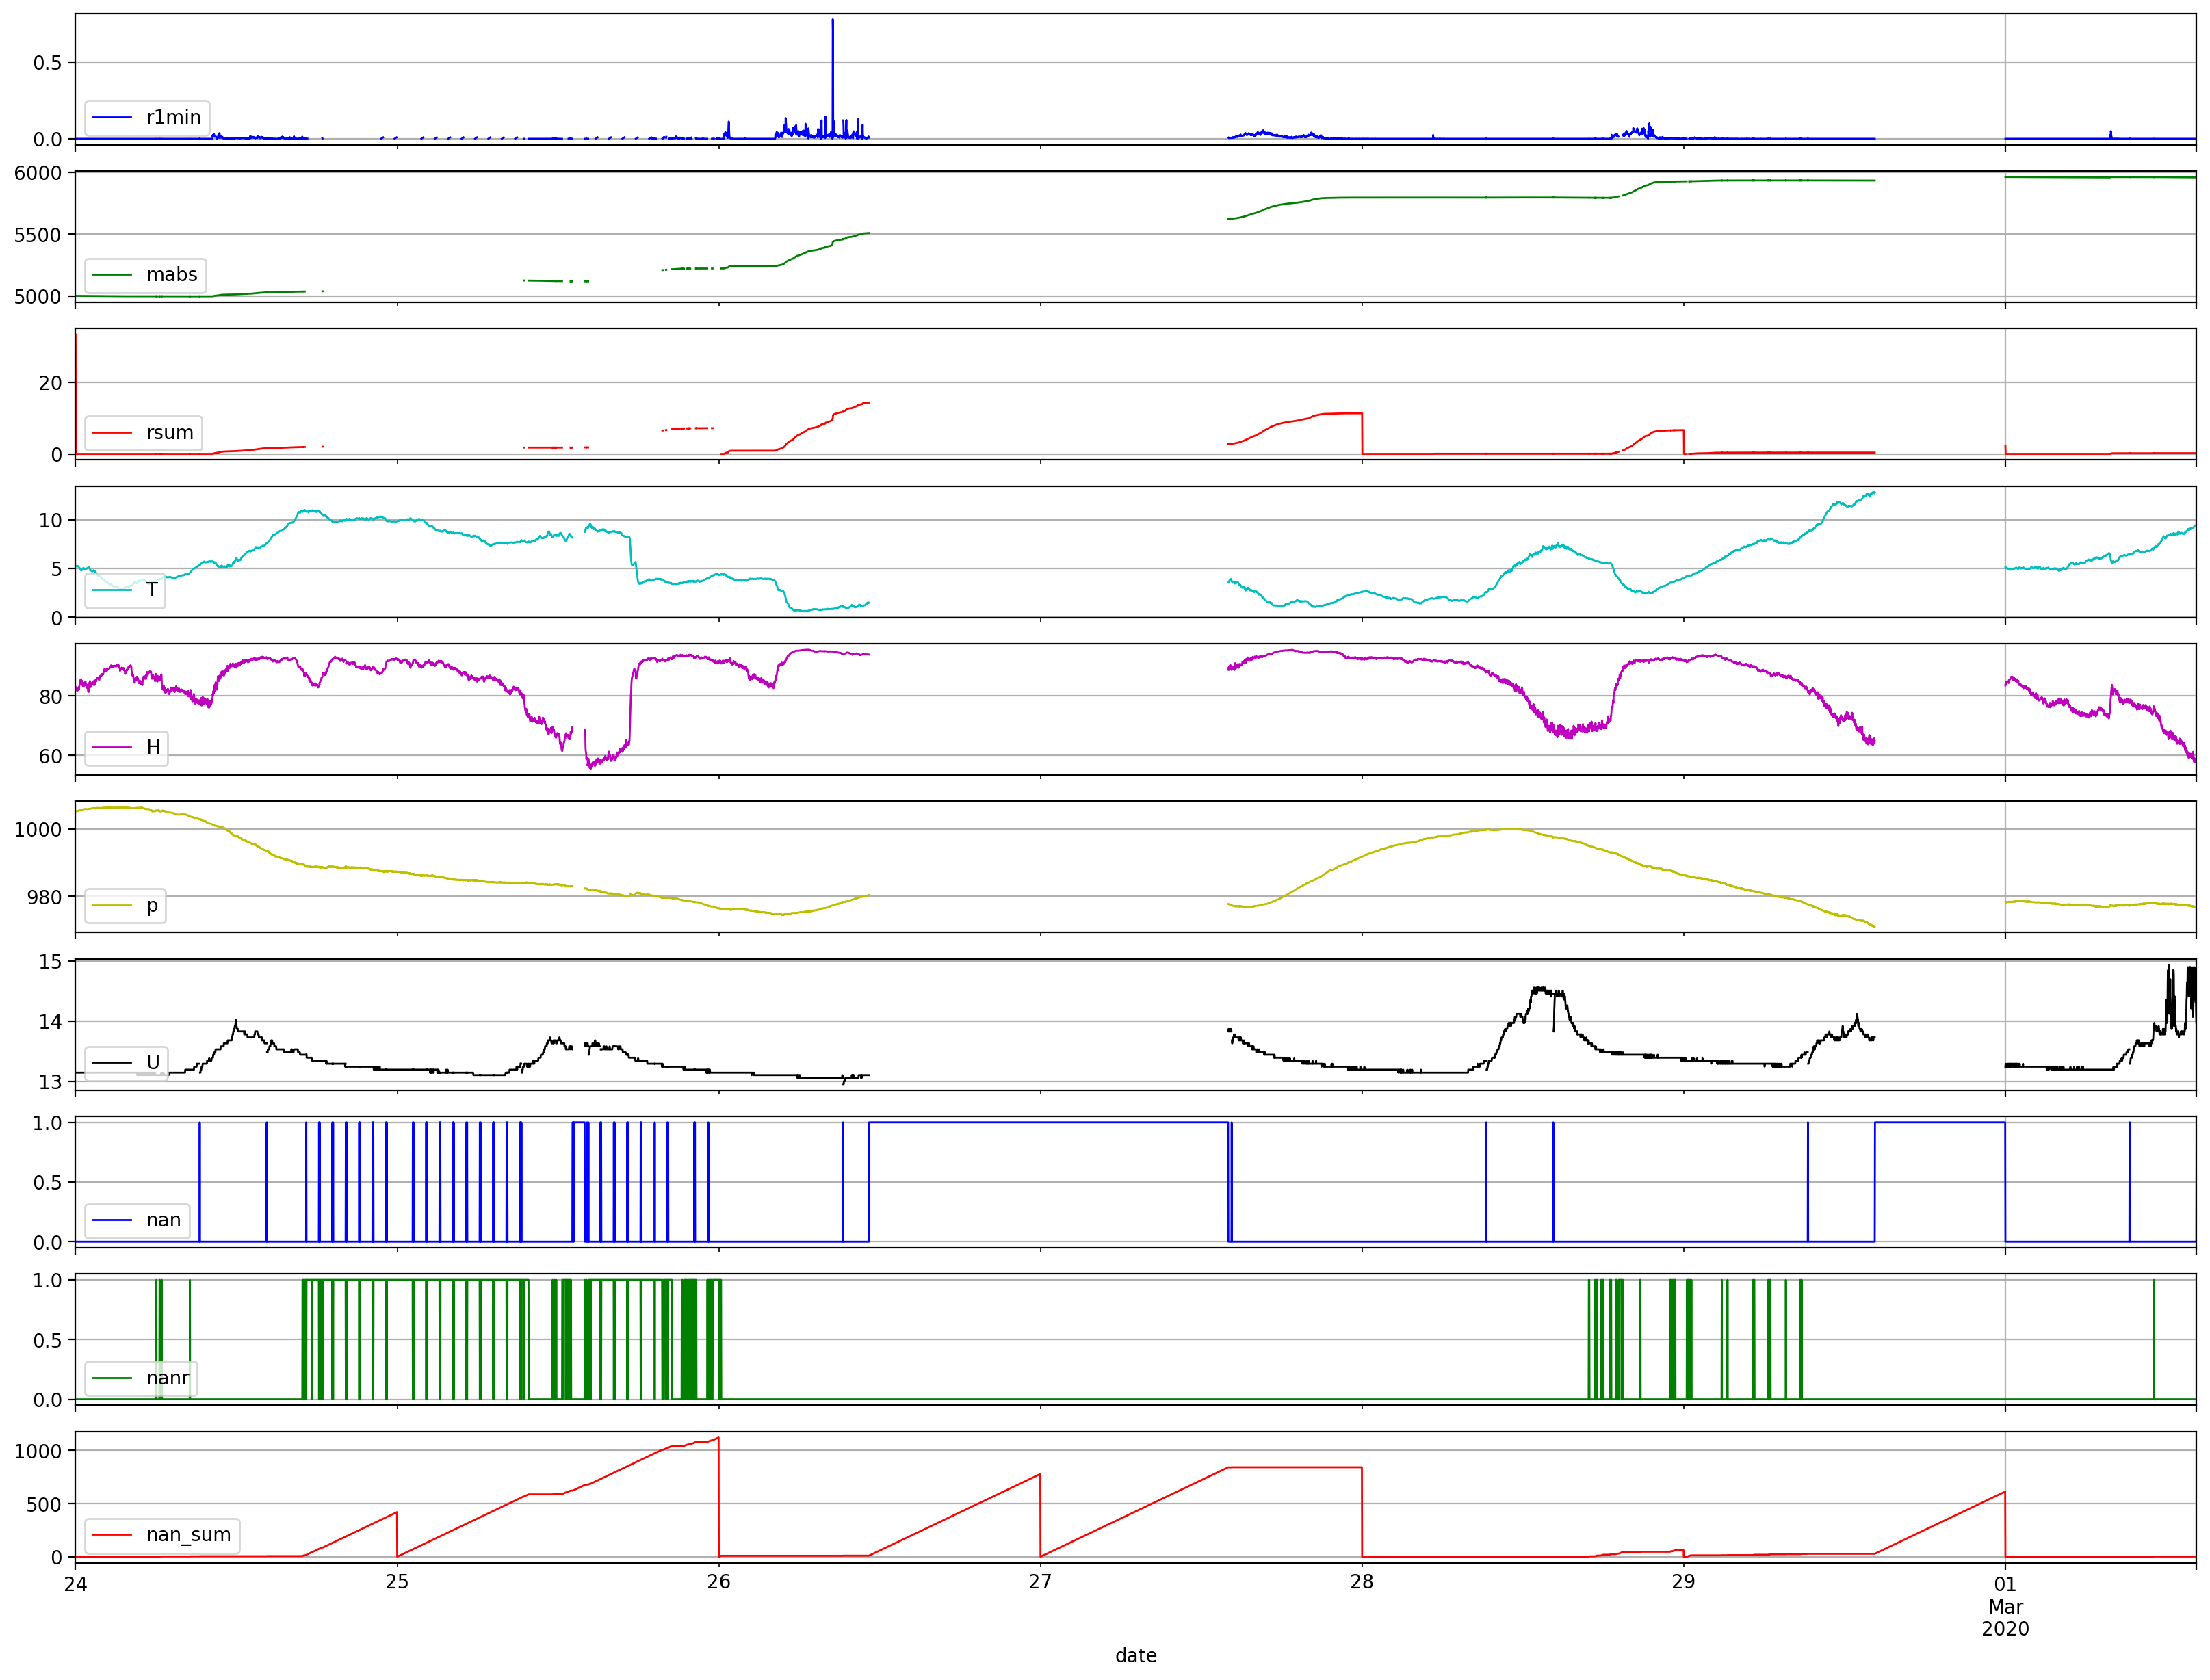

In [10]:
## Darstellung der ganzen Zeitspanne
startdate=str(df.index[0])
enddate=str(df.index[-1])
## alternativ: Festlegen eines Zeitabschnitts zur Darstellung (df muss den Zeitraun abdecken, siehe 2.)
#startdate="2020-02-26 00:00:00"
#enddate="2020-02-26 18:00:00"
## Aufruf der Plot-Funktion (siehe 1.)
plotdf(df,startdate,enddate)
plt.savefig('myplot.png',dpi=300)



## 5. Export der Daten

- Datenframe als csv-Datei sowie Plot als PNG
- Dateien Speichern (siehe Screenshot)

<img src="image1.png" width="300">

In [11]:
df.to_csv('mycsv.csv')


to do:
- dashboard nutzen
- Excel-File erzeugen (incl. Excel-Diagrammen)